# Predict and evaluate SkillsColBERT

In [25]:
# install
# !pip install pytorch-pretrained-bert pytorch-nlp keras scikit-learn matplotlib tensorflow
#!pip install -U sentence-transformers
#https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03 

## Questions:

    a) Dimensions of max function in MaxSim method function.
        - max of column vectors in matrix OR max of row vectors in columns --> 24 dimensional
    b) Training of my ColBERT model
        - [Q] and [D] in vocabulary --> Drop
        - Weights in additional linear layer of 32
        - [MASK] as padding instead of [PAD]
    c) How to save:
        The model (in github) --> Drop
        The document embeddings
        


In [25]:
# BERT imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
from sklearn.metrics import f1_score
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [10]:
# specify CPU or GPU as device
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'
print(f'device = {device}')

device = cpu


In [11]:
# Load data
df = pd.read_csv(r'.\data\skills_description.csv', sep='\t', encoding='utf-8')
df = df.rename(columns={'preferredLabel':'query', 'description': 'documents'})
df = df[['query', 'documents']]

df

,query,documents
0,lede musikalsk personale,Tildele og forvalte personaleopgaver på område...
1,føre tilsyn med fængselsprocedurer,Føre tilsyn med driften af et fængsel eller an...
2,anvende antioppressiv praksis,"Identificere undertrykkelse i samfund, økonomi..."
3,kontrollere overensstemmelse med jernbaneforsk...,"Inspicere rullende materiel, komponenter og sy..."
4,identificere tilgængelige tjenester,"Identificere de forskellige tjenester, der er ..."
...,...,...
13480,forbedre sundhedsbrugers erhvervsevne,"Forbedre eller genoprette de kognitive, sensor..."
13481,installere lys i transportudstyr,Montere lyselementer i transportudstyr i henho...
13482,taleprogsbehandling,"Teknologier, der gør IKT-udstyr i stand til at..."
13483,koordinere bygge- og anlægsaktiviteter,Koordinere flere bygningsarbejderes eller hold...


In [13]:
# Make query embeddings or load them
#q_outputs = torch.tensor(model.encode(df['query'])).to(device)
#q_outputs = torch.load(r'J:\VOA\MABI\Deep Learning\SkillsColBERT\xlm_embeddings\xlm_query_embeddings_tensor.pt')
#print(q_outputs.shape)

# Make document embeddings or load them
#d_outputs = torch.tensor(model.encode(df['documents'])).to(device)
#d_outputs = torch.load(r'J:\VOA\MABI\Deep Learning\SkillsColBERT\xlm_embeddings\xlm_doc_embeddings_tensor.pt')
#print(d_outputs.shape)

#torch.save(q_outputs, r'J:\VOA\MABI\Deep Learning\SkillsColBERT\xlm_embeddings\xlm_query_embeddings_tensor.pt')
#torch.save(d_outputs, r'J:\VOA\MABI\Deep Learning\SkillsColBERT\xlm_embeddings\xlm_doc_embeddings_tensor.pt')

# Import model
Queries and documents have now been tokenized to the vocabolary

## Load Query and Document embeddings

In summary, given a query sequence $q = q_0 q_1...q_l$ and a document sequence $d = d_0 d_1...d_n$, we compute the bags of embeddings $E_q$ and $E_d$ in the following manner:

* $E_q$ := Normalize( CNN( BERT(“[Q]$q_0 q_1...q_l$ ##...#”) ) )

* $E_d$ := Normalize( CNN( BERT(“[D]$d_0 d_1...d_l$ ...d_n”) ) )

where '#' refers to the [mask] tokens. 

In the baseline SBERT the output dimensions are as follow:
\begin{align*}
    dim(E_q) = [1 \times 768] \\
    dim(E_d) = [1 \times 768]
\end{align*}

\begin{align*}
    dim(E_Q) = [13,485 \times 768] \\
    dim(E_D) = [13,485 \times 768]
\end{align*}


but with ColBert the last dimension is reduced to 132 by an additional linear layer, such that my implementation of ColBERT, the output dimensions are as follow:
\begin{align*}
    dim(E_q) = [1 \times 132] \\
    dim(E_d) = [1 \times 132]
\end{align*}

In practice the MaxSim score is implemented such that 1 query is evaluated against all ducuments. Therefore the relevant dimensions are:
\begin{align*}
    dim(E_q) = [13,485 \times 132] \\
    dim(E_D) = [13,485 \times 132]
\end{align*}


### The relevancy score, MaxSim, is defined as follows:
$$ S_{Q,D} =  E_{Q} * E_{D}^T$$
$$dim(S_{Q,D}) = [13,485 \times 13,485] $$

The MaxSim score rates alle combinations of queries and documents. The most similar document is 
$$\underset{j\in ||D||}{\max}  S_{Q,D} $$
$$\dim(\underset{j\in ||D||}{\max}  S_{Q,D}) = [13.485 \times 1]$$



In [20]:
mm = torch.matmul(q_outputs, torch.t(d_outputs))
maxSim, maks_idx = torch.max(mm, dim=1)

maxSim.shape

torch.Size([13485])

tensor(2792)

In [8]:
def accuracy_top_k(Q, pred_idx):
    '''Return the accuracy score of correct predictions in top k'''
    yes_no = []
    for i in range(Q.shape[0]):
        yes_no.append(i in pred_idx[i])

    return np.sum(yes_no) / Q.shape[0]

## Define Model

In [29]:
from sentence_transformers import SentenceTransformer, util

SBERT = SentenceTransformer('sentence-transformers/stsb-xlm-r-multilingual')
SBERT.to(device)


class MyColBERT(nn.Module):
      def __init__(self):
            super(MyColBERT, self).__init__()
            self.SBERT = SBERT 
            ### New layers:
            self.linear1 = nn.Linear(768, 132) 

            # Freeze parameters of BERT Base as I only will train last layer
            for param in SBERT.parameters():
                  param.requires_grad = False
          

      def forward(self, queries, documents , dist_measure='MaxSim'):


            query_embeddings = torch.tensor(SBERT.encode(queries)).to(device)
            query_embeddings = self.linear1(query_embeddings)
            query_embeddings = F.normalize(query_embeddings, p=2.0, dim=1, eps=1e-12, out=None)
            #query_embeddings = F.softmax(query_embeddings, dim=1)

            doc_embeddings = torch.tensor(SBERT.encode(documents)).to(device)
            doc_embeddings = self.linear1(doc_embeddings)
            doc_embeddings = F.normalize(doc_embeddings, p=2.0, dim=1, eps=1e-12, out=None)
            #doc_embeddings = F.softmax(doc_embeddings, dim=1)

            # Compute score for a query against all documents (in batch) 
#            score = F.softmax(self.MaxSim(query_embeddings[q_index], doc_embeddings), dim=0)
            if dist_measure=='MaxSim':
                  sim_score, sim_idx = self.xlmMaxSim(query_embeddings, doc_embeddings)
            elif dist_measure=='MinEuc': 
                  sim_score, sim_idx = self.MinEuc(query_embeddings, doc_embeddings)

            return sim_score, sim_idx

      
      def xlmMaxSim(Q,D):
            '''Return the maximum similarity score (maxSim) for all query-document combinations
               and the id (maks_idx) of the most similar document for each query.

            Keyword arguments:
            Q -- tensor of all queries' embeddings 
            D -- tensor of all documents' embeddings
            '''

            mm = torch.matmul(Q, torch.t(D))

            maxSim, maks_idx = torch.max(mm, dim=1) # dim=1 or dim=2

            return maxSim, maks_idx

      
      def MinEuc(Q, D):
            '''Return the smallest euclidean distance (min_dist) for all query-document combinations
               and the id (min_idx) of the closest document for each query.

                Keyword arguments:
                Q -- tensor of all queries' embeddings 
                D -- tensor of all documents' embeddings
                '''

            # Euclidean distance between queries Q against all documents (in D)
            EucDist = torch.cdist(Q, D, p=2, compute_mode = 'use_mm_for_euclid_dist_if_necessary')

            min_dist, min_idx = torch.min(EucDist, dim=1) # dim=1 or dim=2

            return min_dist, min_idx
                  

In [30]:
my_colbert = MyColBERT()


In [32]:
raw_queries=df['query'].iloc[:5]
raw_documents=df['documents'].iloc[:5]

sim_score, sim_idx= my_colbert(queries=raw_queries, documents=raw_documents , dist_measure='MaxSim')

In [ ]:
Q_ID = torch.tensor(df.index)

torch.sum(Q_ID == maks_idx)



# Train Sentence Bert XLM RoBERTa

## MaxSim implementation

In [11]:
# Calculate MaxSim and assign most similar document ID for each query
maks, maks_idx = xlmMaxSim(Q=q_outputs, D=d_outputs)

# Create query ids (0-13,485)
most_similar_docID = maks_idx
q_IDs = [x for x in range(q_outputs.shape[0])]

# Due to the unchanged order - IDs are also the true labls
y_true = q_IDs
y_pred = most_similar_docID

# Calculate and display f1-score
print('f_1score: ', round(f1_score(y_true, y_pred, average='weighted'),4))

# Calculate correct and wrong predictions
rights = sum(np.array(y_true) == np.array(y_pred))
wrongs = sum(np.array(y_true) != np.array(y_pred))

# Calculate and display accuracy score
print(f'rights: {rights} out of {rights+wrongs} \n {np.round(rights/(rights+wrongs)*100,3)}% accuracy')


f_1score:  0.1489
rights: 2792 out of 13485 
 20.704% accuracy


In [12]:
# In top k
k=10

# Similarity calculation
mm = torch.matmul(q_outputs, torch.t(d_outputs))

# find to k most similar
maxSim, maks_idx = torch.topk(mm, k, largest=True)

top_k_acc = accuracy_top_k(Q=q_outputs, pred_idx=maks_idx)

print(f'Top {k} accuracy: {np.round(top_k_acc*100,2)}%' )

Top 10 accuracy: 50.73%


In [13]:
# Distribution of "predictions"
plt.figure(figsize=(18, 8), dpi=80)
plt.hist(most_similar_docID, bins=q_outputs.shape[0])
plt.title('Distribution of predictions of Maximum Similarity', fontsize=32)
plt.xlabel('Document ID', fontsize=28)

plt.ylabel('No. of predictions', fontsize=28)
plt.ylim(0,80)

plt.savefig(r'J:\VOA\MABI\Deep Learning\my_DTU_project\images\xlm_distribution_MaxSim.png')
plt.show()

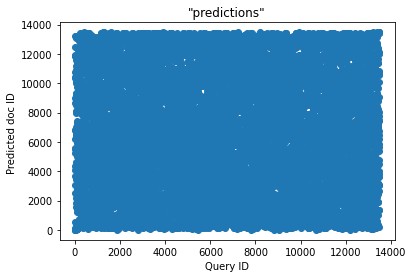

In [48]:
# Distribution of "predictions"
plt.scatter(q_IDs, most_similar_docID)
plt.title('"predictions"')
plt.xlabel('Query ID')
plt.ylabel('Predicted doc ID ')
plt.show()

In [12]:
df_correct = df.loc[(np.array(y_true) == np.array(y_pred))]
df_correct

,query,documents
12,udføre gadeinterventioner i forbindelse med so...,Gennemføre outreachaktiviteter ved at give dir...
15,udføre forskning af flora,Indsamle og analysere data om planter med henb...
18,undervise i husholdning,Undervise i såvel husholdning som manuelle fær...
28,producere guitarkomponenter,"Vælg det relevante tonetræ, materialer og værk..."
29,betjene landbrugsmaskiner,"Betjene motordrevet landbrugsudstyr, herunder ..."
...,...,...
13456,overvågningsmetoder,"Overvågningsmetoder, der anvendes til indsamli..."
13463,indsamle husholdningsaffald,Indsamle ikke-farligt affald fra beboelsesområ...
13465,typer af borebits,Egenskaber og anvendelser af forskellige typer...
13471,stofafhængighed,"Afhængighed af stoffer som alkohol, ordineret ..."


## Example of implementation of MINIMUM Eucledian distance

In [61]:
# Compute euclidean distance and store documents that are close
min_dist, min_idx = MinEuc(Q=q_outputs, D=d_outputs)

# Store in numpy array and create query ids (0-13,485)
most_similar_docID = np.array(min_idx)
q_IDs = [x for x in range(q_outputs.shape[0])]

# Due to the unchanged order - IDs are also the true labls
y_true = q_IDs
y_pred = most_similar_docID

# Calculate and display f1-score
print('f_1score: ', round(f1_score(y_true, y_pred, average='weighted'),4))

# Calculate correct and wrong predictions
rights = sum(np.array(y_true) == np.array(y_pred))
wrongs = sum(np.array(y_true) != np.array(y_pred))

# Calculate and display accuracy
print(f'rights: {rights} out of {rights+wrongs} \n {np.round(rights/(rights+wrongs)*100,2)}% accuracy')


f_1score:  0.1756
rights: 3009 out of 13485 
 22.31% accuracy


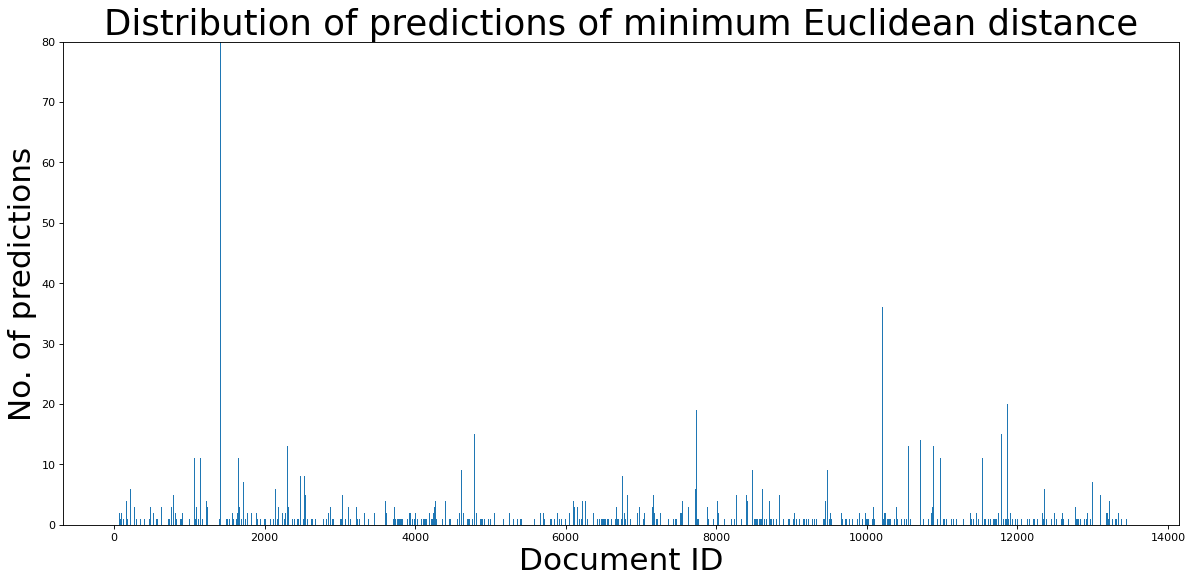

In [72]:
# Distribution of "predictions"
plt.figure(figsize=(18, 8), dpi=80)

plt.hist(most_similar_docID, bins=q_outputs.shape[0])
plt.title('Distribution of predictions of minimum Euclidean distance',  fontsize=32)
plt.xlabel('Document ID', fontsize=28)
plt.ylabel('No. of predictions', fontsize=28)
plt.ylim(0,80)

plt.savefig(r'J:\VOA\MABI\Deep Learning\my_DTU_project\images\xlm_distribution_Euclidean.png')
plt.show()

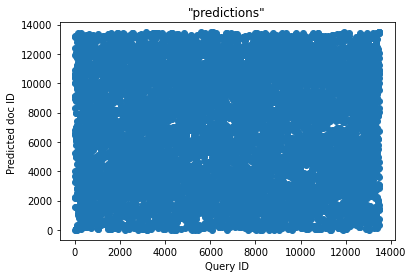

In [19]:
# Distribution of "predictions"
q_IDs = [x for x in range(q_outputs.shape[0])]
plt.scatter(q_IDs, mini_ids)
plt.title('"predictions"')
plt.xlabel('Query ID')
plt.ylabel('Predicted doc ID ')
plt.show()

In [18]:
y_true = q_IDs
y_pred = min_idx

print('f_1score: ', round(f1_score(y_true, y_pred, average='macro'),4))

rights = sum(np.array(y_true) == np.array(y_pred))
wrongs = sum(np.array(y_true) != np.array(y_pred))

print(f'rights: {rights} out of {rights+wrongs} \n {np.round(rights/(rights+wrongs),3)}% accuracy')

f_1score:  0.1756
rights: 3009 out of 13485 
 0.223% accuracy


In [58]:
# In top k
k=5
EucDist = torch.cdist(q_outputs, d_outputs, p=2, compute_mode = 'use_mm_for_euclid_dist_if_necessary')
#mm = torch.matmul(q_outputs, torch.t(d_outputs))

# find to k most similar
minDist, min_idx = torch.topk(EucDist, k, largest=False)

top_k_acc = accuracy_top_k(Q=q_outputs, pred_idx=min_idx)

print(f'Top {k} accuracy: {np.round(top_k_acc*100,2)}%' )

Top 10 accuracy: 50.39%


## Play around yourself

In [25]:
def top_k_skills(raw_sentence, D, k=3, df=df):
    '''Return the top k documents in df that a raw sentence is most similar to'''
    
    # Embed senetence
    embeddings = torch.tensor(model.encode(raw_sentence)).to(device)

    # compute similarity score
    mm = torch.matmul(embeddings, torch.t(D))

    # find to k most similar
    maxSim, maks_idx = torch.topk(mm, k, largest=True)
    
    return df.iloc[np.array(maks_idx)]

In [26]:
raw_sent = "samarbejde med andre"

top_k_skills(raw_sentence=raw_sent, D=d_outputs, k=3, df=df)

,query,documents
8995,udvise sociale kompetencer,Evne til at interagere effektivt med andre.
3803,koordinere med kreative afdelinger,Koordinere aktiviteter med andre kunstneriske ...
501,interagere med andre,Samarbejde med andre ansigt til ansigt i en la...


In [18]:
#kompetence = "samarbejde med andre"
#kompetence = "programmering i sas"
#kompetence = "håndværksfærdigheder"
#kompetence = "anerkendende børnesyn"
kompetence = "coorporate with others"
#kompetence = "god med børn"

top_k_skills(raw_sentence=kompetence, D=d_outputs, k=3, df=df)


,query,documents
3803,koordinere med kreative afdelinger,Koordinere aktiviteter med andre kunstneriske ...
8995,udvise sociale kompetencer,Evne til at interagere effektivt med andre.
11521,organisere arrangementer til flere samtidige p...,"Tilrettelægge arrangementer og programmer, som..."
